In [22]:
# Data Handling and Processing
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
from dotenv import dotenv_values

# Machine Learning Models and Evaluation Metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization (Optional, if you'd like to visualize predictions or residuals)
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')


In [23]:
# Load environment variables
config = dotenv_values()

# Define variables for the login
pg_user = config['POSTGRES_USER']
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

# Set up the PostgreSQL connection URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

# Create the database engine
engine = create_engine(url, echo=False)
my_schema = 'capstone_barstov_industries'

# Load data directly into a DataFrame
with engine.connect() as conn:
    conn.execute(text(f'SET search_path TO {my_schema};'))
    data = pd.read_sql("SELECT * FROM model_data_week;", conn)

# Check the DataFrame structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172968 entries, 0 to 172967
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   product_type_no    172968 non-null  int64              
 1   product_type_name  172968 non-null  object             
 2   colour_group_code  172968 non-null  int64              
 3   colour_group_name  172968 non-null  object             
 4   week               172968 non-null  datetime64[ns, UTC]
 5   average_price      172968 non-null  float64            
 6   total_units_sold   172968 non-null  int64              
 7   unique_customers   172968 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(2)
memory usage: 10.6+ MB


In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure 'week' is in datetime format without timezone
data['week'] = pd.to_datetime(data['week']).dt.tz_localize(None)

# Filter data up to March 2020 and sort
data = data[data['week'] <= "2020-03-01"].copy()
data = data.sort_values(by=['product_type_no', 'colour_group_code', 'week'])

# Step 1: Data-Driven Peak Season Identification Using Quantile-Based Thresholds

# Calculate 90th percentile threshold for peak season within each product-type and color group
demand_clusters = data.groupby(['product_type_no', 'colour_group_code', 'week'])['total_units_sold'].sum().reset_index()
demand_clusters['peak_threshold'] = demand_clusters.groupby(['product_type_no', 'colour_group_code'])['total_units_sold'].transform(lambda x: x.quantile(0.90))

# Flag as peak season if total_units_sold exceeds the 90th percentile threshold
demand_clusters['is_peak_season'] = demand_clusters['total_units_sold'] >= demand_clusters['peak_threshold']

# Merge peak season flags back into main dataset
data = pd.merge(data, demand_clusters[['product_type_no', 'colour_group_code', 'week', 'is_peak_season']], 
                on=['product_type_no', 'colour_group_code', 'week'], how='left')

# Remove duplicate columns if any
if 'is_peak_season_x' in data.columns and 'is_peak_season_y' in data.columns:
    data = data.drop(columns=['is_peak_season_x']).rename(columns={'is_peak_season_y': 'is_peak_season'})

# Step 2: Feature Engineering - Lagged Features and Seasonal Features

data['lag_units_sold_1week'] = data.groupby(['product_type_no', 'colour_group_code'])['total_units_sold'].shift(1)
data['lag_units_sold_2weeks'] = data.groupby(['product_type_no', 'colour_group_code'])['total_units_sold'].shift(2)
data = data.dropna(subset=['lag_units_sold_1week', 'lag_units_sold_2weeks']).reset_index(drop=True)

# Month feature for seasonality
data['month'] = data['week'].dt.month

# Scale the price
data['average_price'] = data['average_price'] * 10

# Step 3: Define train, validation, and test sets
train_data = data[data['week'] < "2020-01-01"]
validation_data = data[(data['week'] >= "2020-01-01") & (data['week'] < "2020-03-01")]
test_data = data[data['week'] == data['week'].max()]

# Step 4: Include `is_peak_season` in the features and proceed with model training

# Define feature columns
feature_columns = [
    'product_type_no', 'colour_group_code', 'average_price',
    'lag_units_sold_1week', 'lag_units_sold_2weeks', 'month', 'is_peak_season'
]

X_train, y_train = train_data[feature_columns], train_data['total_units_sold']
X_validation, y_validation = validation_data[feature_columns], validation_data['total_units_sold']
X_test, y_test = test_data[feature_columns], test_data['total_units_sold']

# Initialize and train base models
model_rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
model_lr = LinearRegression()
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

model_rf.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_mlp.fit(X_train, y_train)

# Generate predictions and round to integers
preds_rf_val = np.round(model_rf.predict(X_validation)).astype(int)
preds_lr_val = np.round(model_lr.predict(X_validation)).astype(int)
preds_mlp_val = np.round(model_mlp.predict(X_validation)).astype(int)

preds_rf_test = np.round(model_rf.predict(X_test)).astype(int)
preds_lr_test = np.round(model_lr.predict(X_test)).astype(int)
preds_mlp_test = np.round(model_mlp.predict(X_test)).astype(int)

# Meta-model predictions
val_predictions_df = pd.DataFrame({'RandomForest': preds_rf_val, 'LinearRegression': preds_lr_val, 'MLPRegressor': preds_mlp_val})
test_predictions_df = pd.DataFrame({'RandomForest': preds_rf_test, 'LinearRegression': preds_lr_test, 'MLPRegressor': preds_mlp_test})

final_model_rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
final_model_rf.fit(val_predictions_df, y_validation)

# Generate and round meta-model predictions
final_preds_val = np.round(final_model_rf.predict(val_predictions_df)).astype(int)
final_preds_test = np.round(final_model_rf.predict(test_predictions_df)).astype(int)

# Calculate metrics
mae_val = mean_absolute_error(y_validation, final_preds_val)
rmse_val = mean_squared_error(y_validation, final_preds_val, squared=False)
mae_test = mean_absolute_error(y_test, final_preds_test)
rmse_test = mean_squared_error(y_test, final_preds_test, squared=False)

print("Extended Validation MAE:", mae_val)
print("Extended Validation RMSE:", rmse_val)
print("Test MAE:", mae_test)
print("Test RMSE:", rmse_test)

# Aggregate inventory needs by product type and color for the test period
test_data['predicted_inventory_needs'] = final_preds_test
inventory_needs = test_data.groupby(['product_type_no', 'colour_group_code'])['predicted_inventory_needs'].sum().reset_index()

# Calculate average demand for each product-type and color combination
avg_demand = data.groupby(['product_type_no', 'colour_group_code'])['total_units_sold'].mean().reset_index()
avg_demand = avg_demand.rename(columns={'total_units_sold': 'avg_demand'})

# Merge average demand back into `test_data`
test_data = pd.merge(test_data, avg_demand, on=['product_type_no', 'colour_group_code'], how='left')
# Define multipliers for peak and non-peak seasons
# Prioritize rebalancing non-peak season items by setting a stricter (lower) threshold
non_peak_season_multiplier = 0.5  # Trigger rebalancing sooner for non-peak items (50% of average demand)
peak_season_multiplier = 1.0      # Allow peak items more space (100% of average demand)

# Calculate the low-demand threshold dynamically based on the seasonality of each item
test_data['low_demand_threshold'] = np.where(
    test_data['is_peak_season'],
    test_data['avg_demand'] * peak_season_multiplier,     # Use peak multiplier for peak season items
    test_data['avg_demand'] * non_peak_season_multiplier  # Use non-peak multiplier for non-peak items
)

# Calculate a rolling 4-week sum of predicted inventory needs to identify low-demand periods
test_data['low_demand_4weeks'] = test_data.groupby(['product_type_no', 'colour_group_code'])['predicted_inventory_needs'] \
    .transform(lambda x: x.rolling(window=4, min_periods=1).sum())

# Flag items for rebalancing based on the dynamic low-demand threshold
test_data['rebalance_flag'] = test_data['low_demand_4weeks'] <= test_data['low_demand_threshold']

# Summarize the flagged items for rebalancing
rebalance_needs = test_data[test_data['rebalance_flag']].groupby(['product_type_no', 'colour_group_code'])['predicted_inventory_needs'].sum().reset_index()
rebalance_needs['rebalance_units'] = np.round(rebalance_needs['predicted_inventory_needs']).astype(int)

# Summarize the overall predicted inventory needs
inventory_needs = test_data.groupby(['product_type_no', 'colour_group_code'])['predicted_inventory_needs'].sum().reset_index()

# Print results
print("\nPredicted Inventory Needs (Test Period):")
print(inventory_needs)

print("\nPotential Rebalance Needs (Dynamic Low Demand Thresholds):")
print(rebalance_needs)

print("Total Predicted Inventory Needs (Test Period):", int(inventory_needs['predicted_inventory_needs'].sum()))
print("Total Rebalance Needs (Low Demand Adjustments):", int(rebalance_needs['rebalance_units'].sum()))
print("Total Actual Units Sold (Test Period):", int(y_test.sum()))


Extended Validation MAE: 9.11397117060035
Extended Validation RMSE: 27.729693937497004
Test MAE: 9.709899749373433
Test RMSE: 31.24383648490914

Predicted Inventory Needs (Test Period):
      product_type_no  colour_group_code  predicted_inventory_needs
0                  -1                  6                         75
1                  -1                  9                        441
2                  -1                 10                         93
3                  -1                 12                         60
4                  -1                 13                         15
...               ...                ...                        ...
1591              512                 53                         19
1592              515                 11                          2
1593              525                  3                          2
1594              529                 52                         21
1595              532                  9                         6

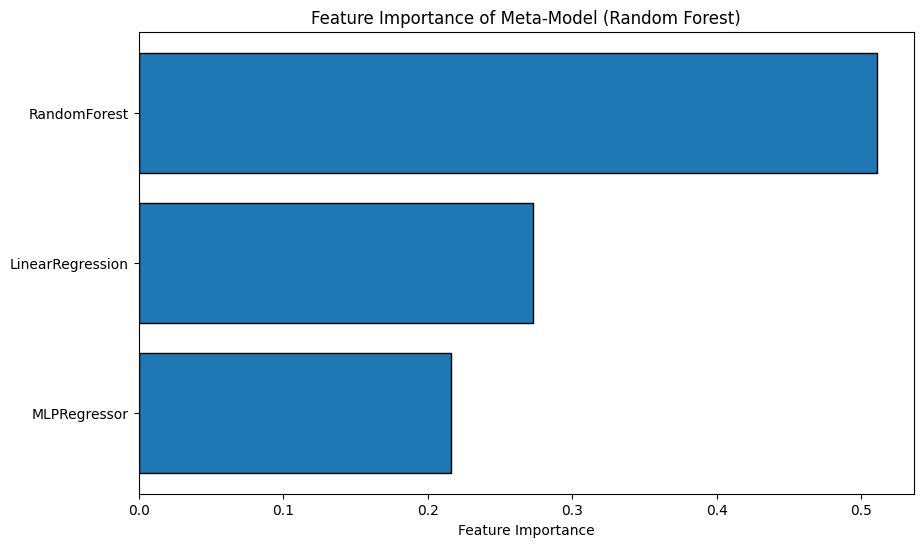

In [18]:
import matplotlib.pyplot as plt

# Fit the final RandomForestRegressor meta-model on the validation predictions if not already fitted
# Uncomment the following if you need to re-fit, otherwise skip this step
# final_model_rf.fit(val_predictions_df, y_validation)

# Extract feature importance from the final meta-model (RandomForestRegressor)
feature_importances = final_model_rf.feature_importances_

# Since the meta-model uses the predictions of the base models, we'll label the features as the base models
feature_labels = val_predictions_df.columns

# Create a DataFrame to hold feature importance values for easy plotting
importance_df = pd.DataFrame({
    'Feature': feature_labels,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], edgecolor='black')
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Meta-Model (Random Forest)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


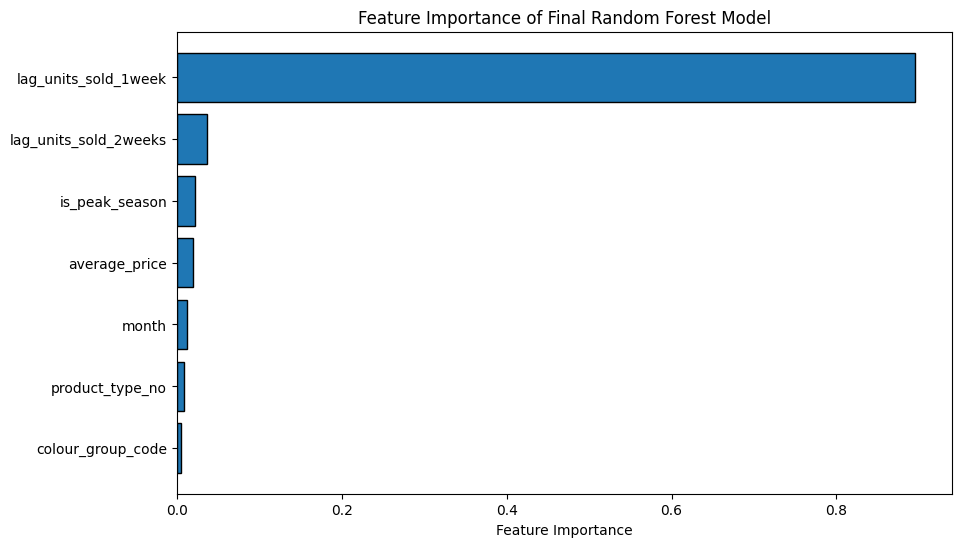

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `model_rf` is the final RandomForestRegressor model trained on the original features

# Extract feature importances from the model
feature_importances = model_rf.feature_importances_

# Define the feature names (these should match the columns used in training)
feature_labels = [
    'product_type_no', 'colour_group_code', 'average_price',
    'lag_units_sold_1week', 'lag_units_sold_2weeks', 'month', 'is_peak_season'
]

# Create a DataFrame to hold feature importance values for easy plotting
importance_df = pd.DataFrame({
    'Feature': feature_labels,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], edgecolor='black')
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Final Random Forest Model")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [20]:
# Initialize an empty DataFrame to store predictions for each future week
future_predictions = pd.DataFrame()

# Copy the last week's data to use for initial predictions
last_week_data = test_data.copy()  # Assuming test_data is the final week of actual data

# Initialize a rolling window for tracking low-demand predictions
last_week_data['low_demand_4weeks'] = last_week_data['total_units_sold']  # Start with current units sold

# Predict for 4 future weeks
for week_ahead in range(1, 5):
    # Prepare features for prediction using the last week's data
    X_future = last_week_data[feature_columns]  # feature_columns should include all necessary features
    
    # Step 1: Generate predictions from each base model for the current week
    preds_rf = model_rf.predict(X_future)
    preds_lr = model_lr.predict(X_future)
    preds_mlp = model_mlp.predict(X_future)
    
    # Step 2: Create DataFrame with base model predictions to input to the meta-model
    base_preds_df = pd.DataFrame({
        'RandomForest': preds_rf,
        'LinearRegression': preds_lr,
        'MLPRegressor': preds_mlp
    })
    
    # Step 3: Use the meta-model to predict the final units sold
    future_pred = final_model_rf.predict(base_preds_df)
    
    # Step 4: Store predictions in a DataFrame with the week number (1 to 4)
    prediction_df = last_week_data[['product_type_no', 'product_type_name', 
                                    'colour_group_code', 'colour_group_name']].copy()
    prediction_df['predicted_units_sold'] = np.round(future_pred).astype(int)  # Ensure integer values
    prediction_df['week_ahead'] = week_ahead  # Label the future week
    
    # Step 5: Calculate rolling 4-week cumulative demand for the low-demand rebalancing feature
    # Update `low_demand_4weeks` with the current prediction and check if it meets the threshold
    last_week_data['low_demand_4weeks'] = last_week_data['low_demand_4weeks'] + future_pred - last_week_data['low_demand_4weeks'].shift(1).fillna(0)
    
    # Flag for rebalancing if cumulative demand falls below threshold
    prediction_df['rebalance_flag'] = np.where(
        (last_week_data['is_peak_season'] & (last_week_data['low_demand_4weeks'] <= low_demand_threshold)) |
        (~last_week_data['is_peak_season'] & (last_week_data['low_demand_4weeks'] <= (low_demand_threshold * 1.5))),
        True,
        False
    )
    
    # Append the predictions to the future_predictions DataFrame
    future_predictions = pd.concat([future_predictions, prediction_df], ignore_index=True)
    
    # Step 6: Update last_week_data to simulate moving into the next week
    # Shift lagged features: set 2-week lag to previous 1-week lag, and set 1-week lag to current prediction
    last_week_data['lag_units_sold_2weeks'] = last_week_data['lag_units_sold_1week']
    last_week_data['lag_units_sold_1week'] = future_pred  # Set new lag as current prediction
    
    # Update `total_units_sold` for accurate rolling calculations in the next week
    last_week_data['total_units_sold'] = np.round(future_pred).astype(int)

# Display the resulting DataFrame with predictions and rebalancing flags for 4 future weeks
print("\nFuture Predictions with Rebalance Flags for 4 Weeks Out:")
print(future_predictions)



Future Predictions with Rebalance Flags for 4 Weeks Out:
      product_type_no product_type_name  colour_group_code colour_group_name  \
0                  -1           Unknown                  6        Light Grey   
1                  -1           Unknown                  9             Black   
2                  -1           Unknown                 10             White   
3                  -1           Unknown                 12       Light Beige   
4                  -1           Unknown                 13             Beige   
...               ...               ...                ...               ...   
6379              512         Hair ties                 53         Dark Pink   
6380              515         Straw hat                 11         Off White   
6381              525          Keychain                  3            Silver   
6382              529       Mobile case                 52              Pink   
6383              532          Umbrella                  9    

In [24]:
# Set up the schema if needed and push inventory_needs to PostgreSQL
with engine.connect() as conn:
    conn.execute(text(f'SET search_path TO {my_schema};'))
    future_predictions.to_sql('future_predictions', con=engine, schema=my_schema, if_exists='replace', index=False)

print("Table successfully pushed to the database!")


Table successfully pushed to the database!
